In [4]:
run run_residuals -v -o 2

/Users/Natalie/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Initialization runtime 19.01 s
Number of stars 484

Maximum SNR before correction 200.00
SNR correction runtime 0.15 s
Maximum SNR before correction 200.00

Nonzero Minimum SNR before mask 50.0000
SNR cut runtime 0.00 s
Minimum SNR after mask 50.0000

Bitmask application runtime 0.00 s

Pixel residuals runtime 0.26 s
Maximum residual 0.1938813389 

Finding random sigma runtime 0.51 s



In [5]:
hidefigs = False
import numpy as np
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [6]:
totalstars = np.sum(starsample.numstars.values())
allresids = np.ma.masked_array(np.zeros((totalstars,aspcappix)))
allsigmas = np.ma.masked_array(np.zeros((totalstars,aspcappix)))
apoSNR = np.zeros((totalstars))
maSNR = np.zeros((totalstars))
i = 0
for subgroup in starsample.subgroups:
    match = np.where(starsample.data[starsample.subgroup]==subgroup)
    allresids[i:i+starsample.numstars[subgroup]] = starsample.residual[subgroup].T
    allsigmas[i:i+starsample.numstars[subgroup]] = starsample.errs[match]
    apoSNR[i:i+starsample.numstars[subgroup]] = starsample.data[match]['SNR']
    maSNR[i:i+starsample.numstars[subgroup]] = np.ma.mean(starsample.specs[match]/starsample.errs[match],axis=1)
    i += starsample.numstars[subgroup]

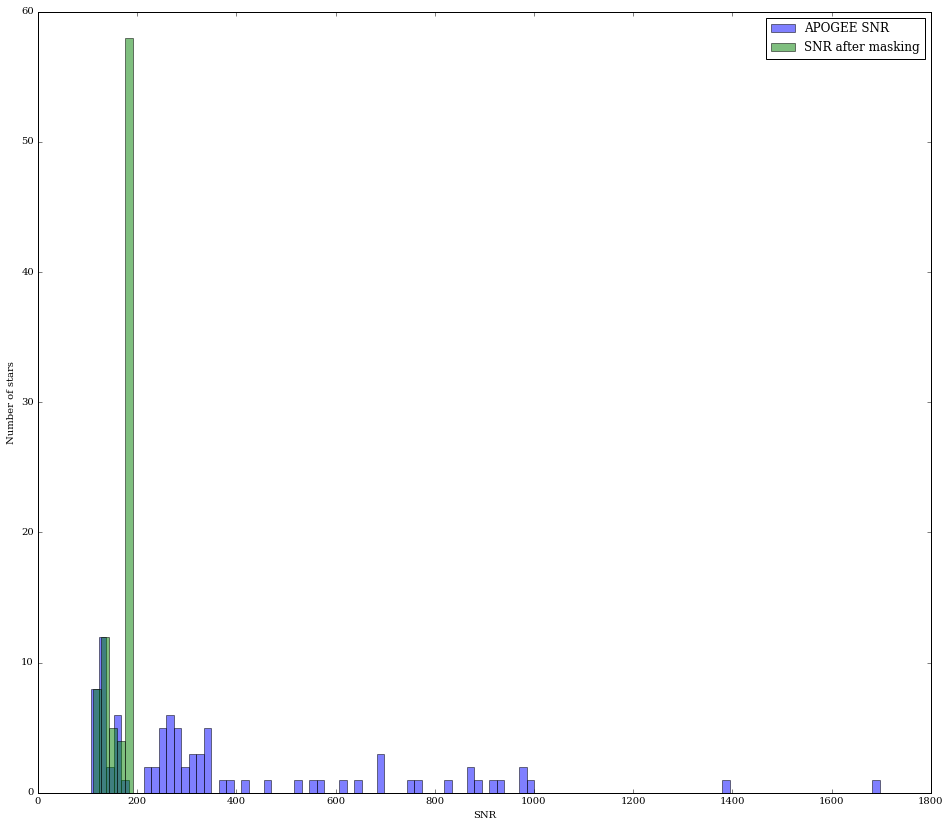

In [7]:
# Plot SNR histogram

SNRhist,SNRbins = np.histogram(apoSNR,bins = 105)
maSNRhist,maSNRbins = np.histogram(maSNR,bins=5)
plt.figure(figsize=(16,14))
plt.bar(SNRbins[:-1],SNRhist,width = (SNRbins[1]-SNRbins[0]),label='APOGEE SNR',alpha=0.5)
plt.bar(maSNRbins[:-1],maSNRhist,width = (maSNRbins[1]-maSNRbins[0]),color='green',alpha=0.5,label='SNR after masking')
plt.xlabel('SNR')
plt.ylabel('Number of stars')
plt.legend(loc = 'best')


M67
       iter        R2             rchi2
EMPCA  1/25       0.02926886      0.00004558
EMPCA  2/25       0.53739941      0.00002172
EMPCA  3/25       0.59774796      0.00001889
EMPCA  4/25       0.61857550      0.00001791
EMPCA  5/25       0.62571742      0.00001758
EMPCA  6/25       0.62840176      0.00001745
EMPCA  7/25       0.62948998      0.00001740
EMPCA  8/25       0.62996806      0.00001738
EMPCA  9/25       0.63019278      0.00001736
EMPCA 10/25       0.63030150      0.00001736
EMPCA 11/25       0.63035064      0.00001736
EMPCA 12/25       0.63036385      0.00001736
EMPCA 13/25       0.63034966      0.00001736
EMPCA 14/25       0.63030819      0.00001736
EMPCA 15/25       0.63023329      0.00001736
EMPCA 16/25       0.63011253      0.00001737
EMPCA 17/25       0.62992618      0.00001738
EMPCA 18/25       0.62964669      0.00001739
EMPCA 19/25       0.62924226      0.00001741
EMPCA 20/25       0.62869208      0.00001744
EMPCA 21/25       0.62802000      0.00001747
EMPCA 22/25

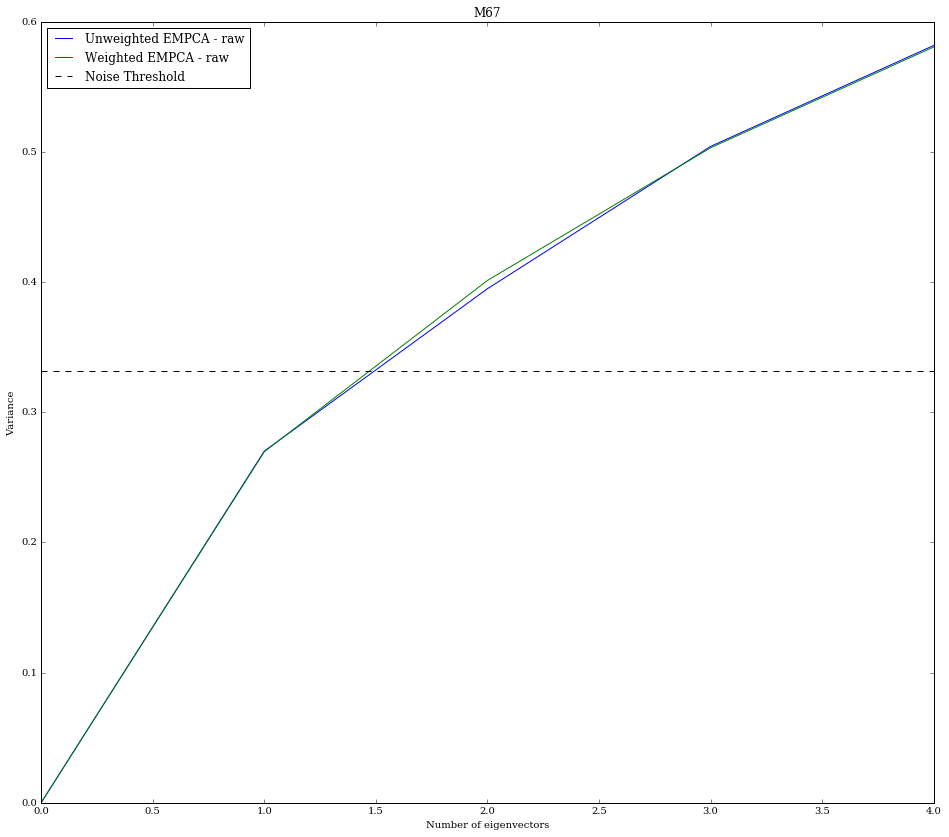

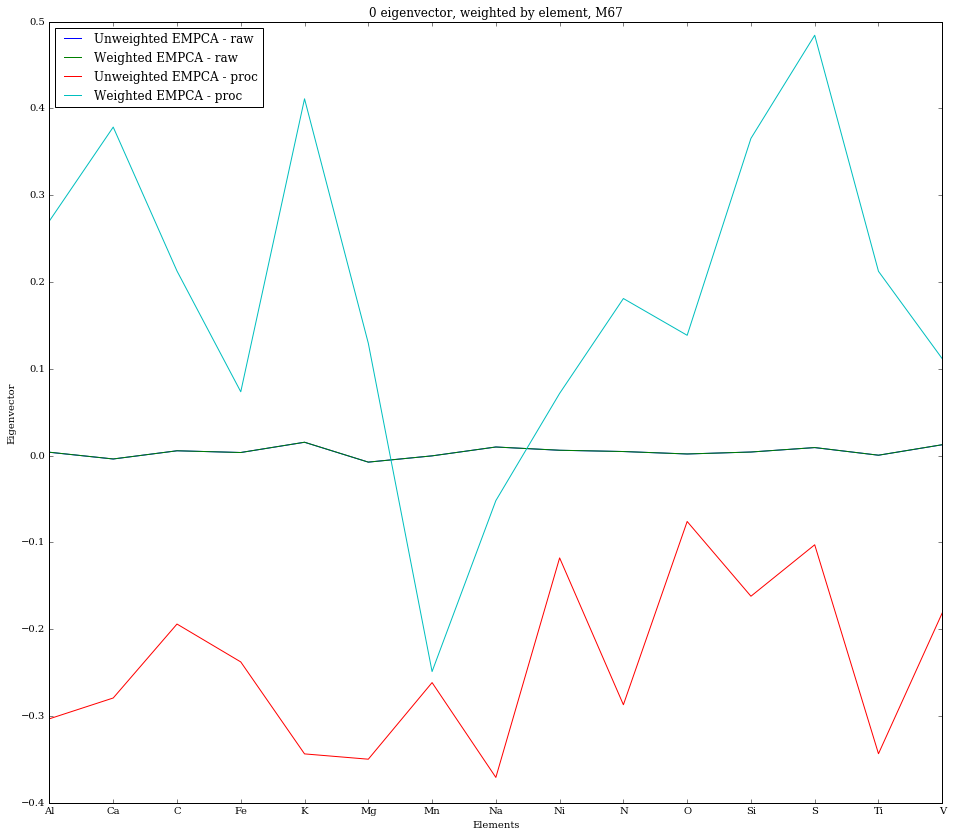

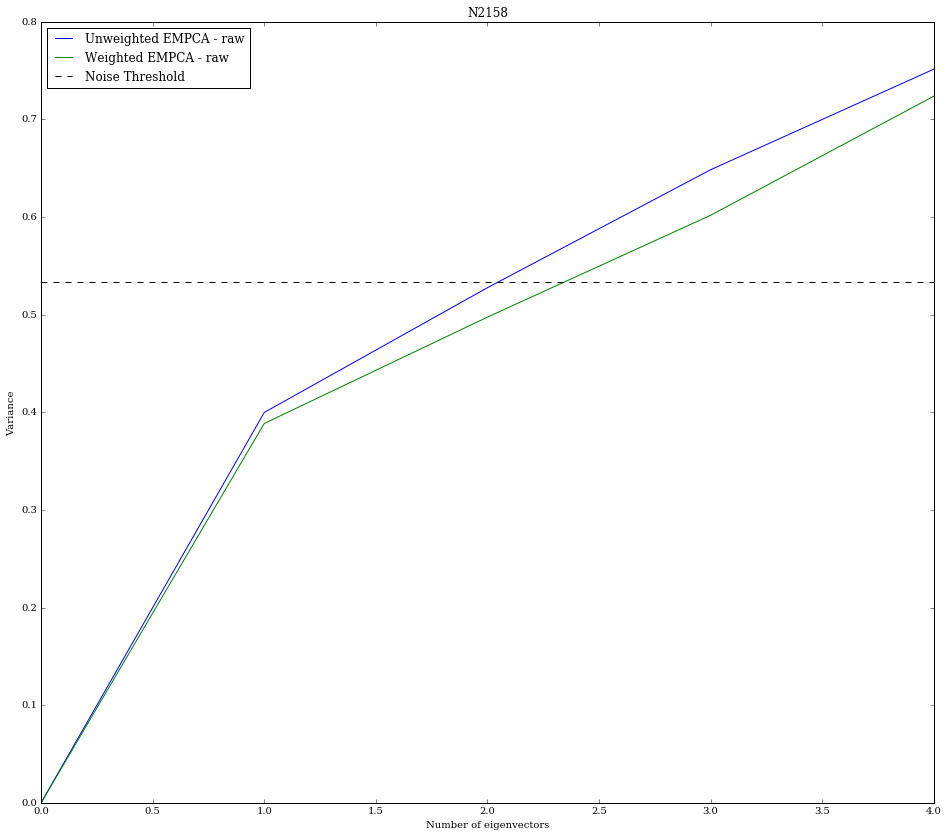

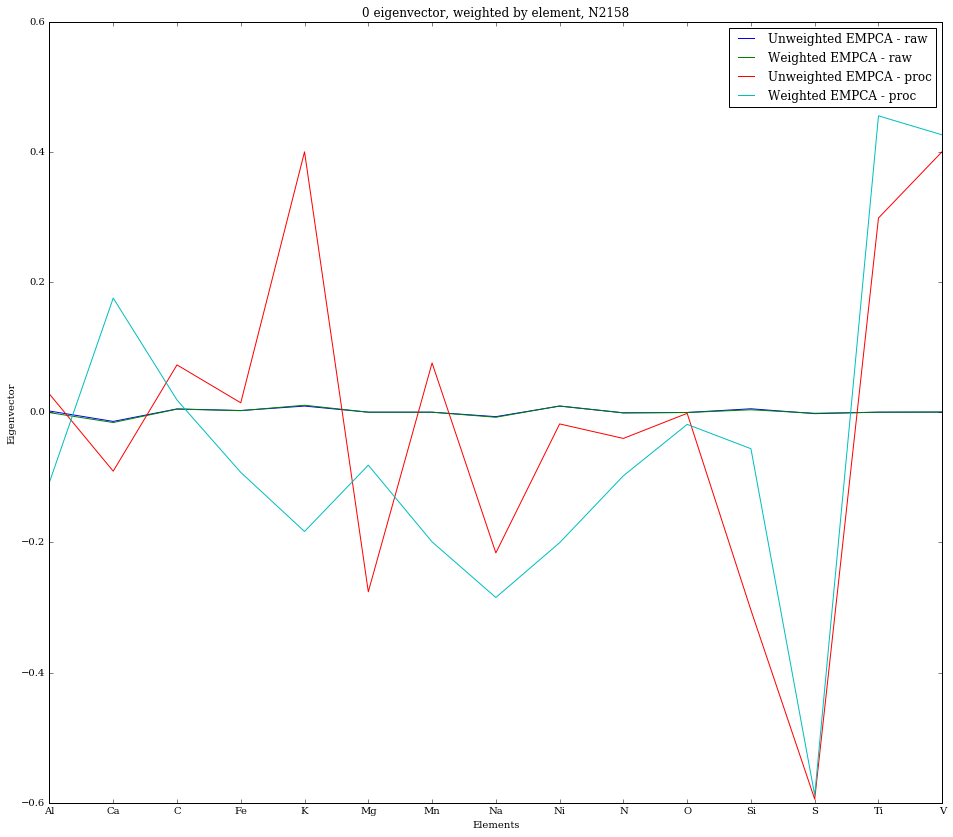

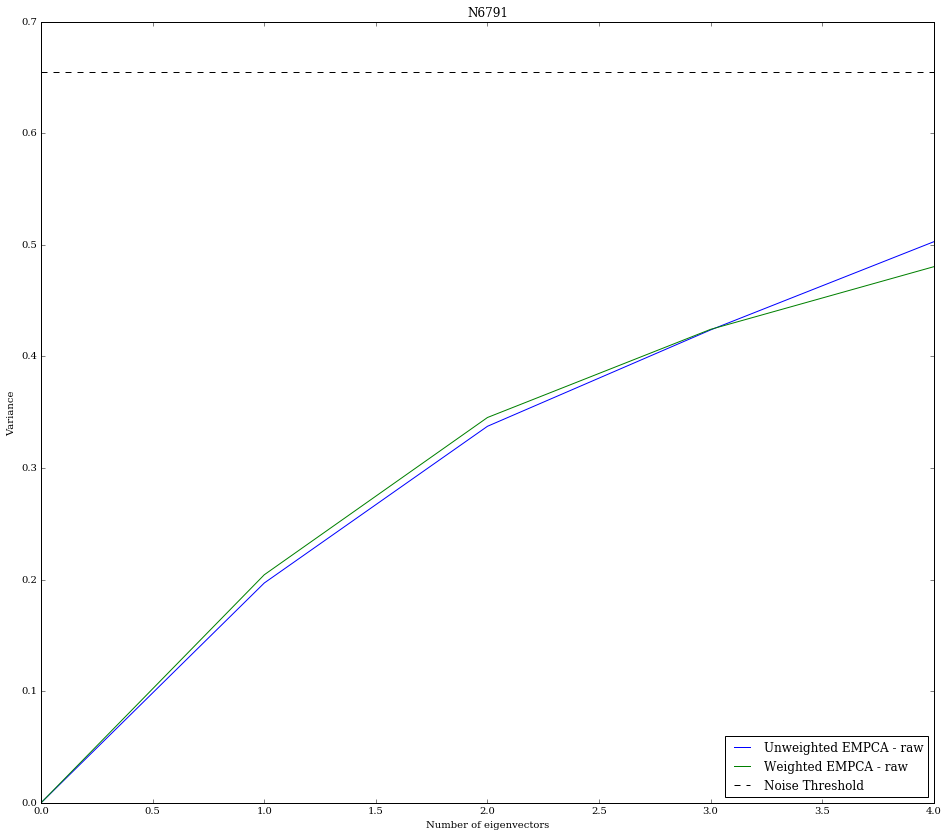

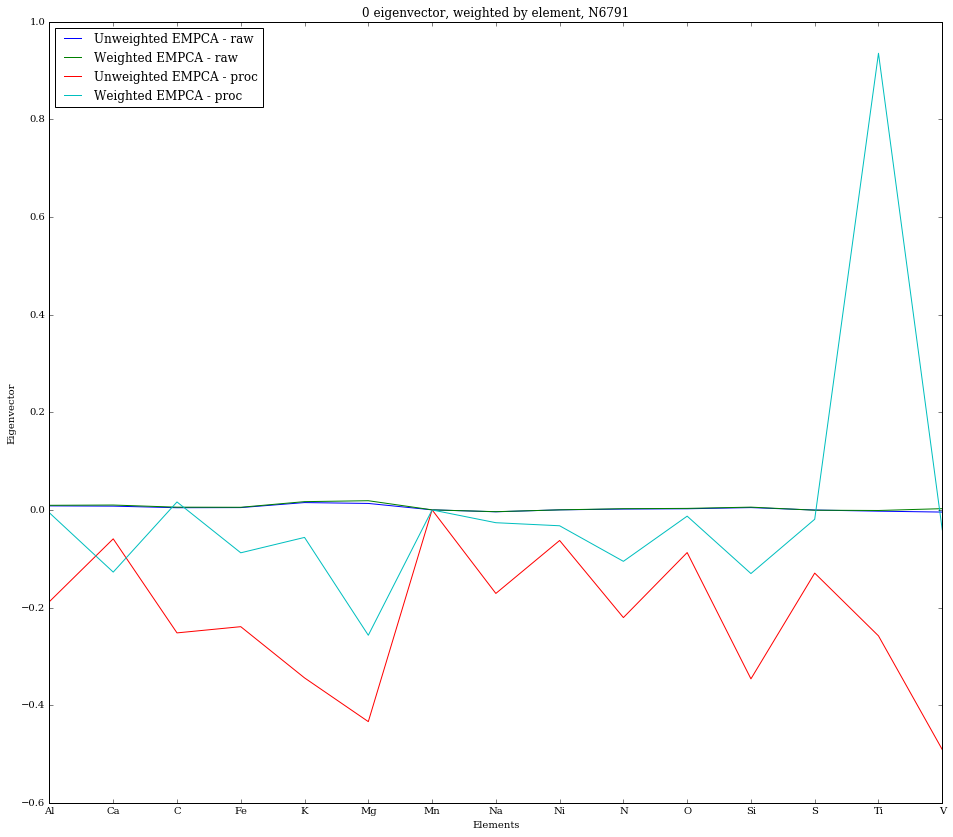

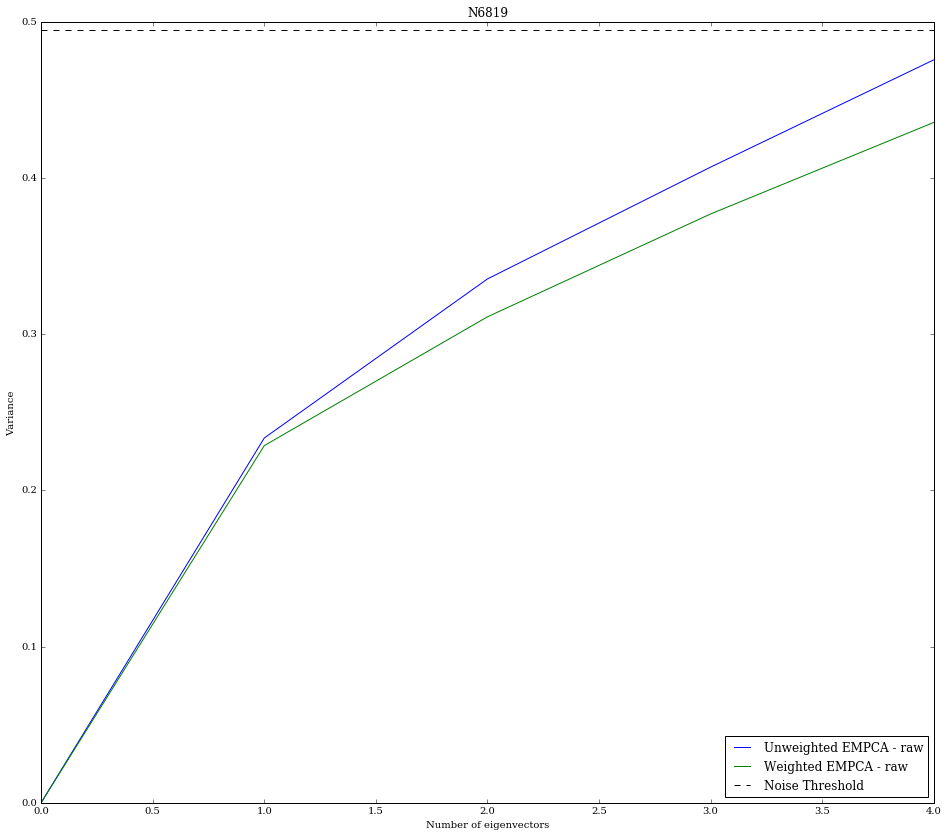

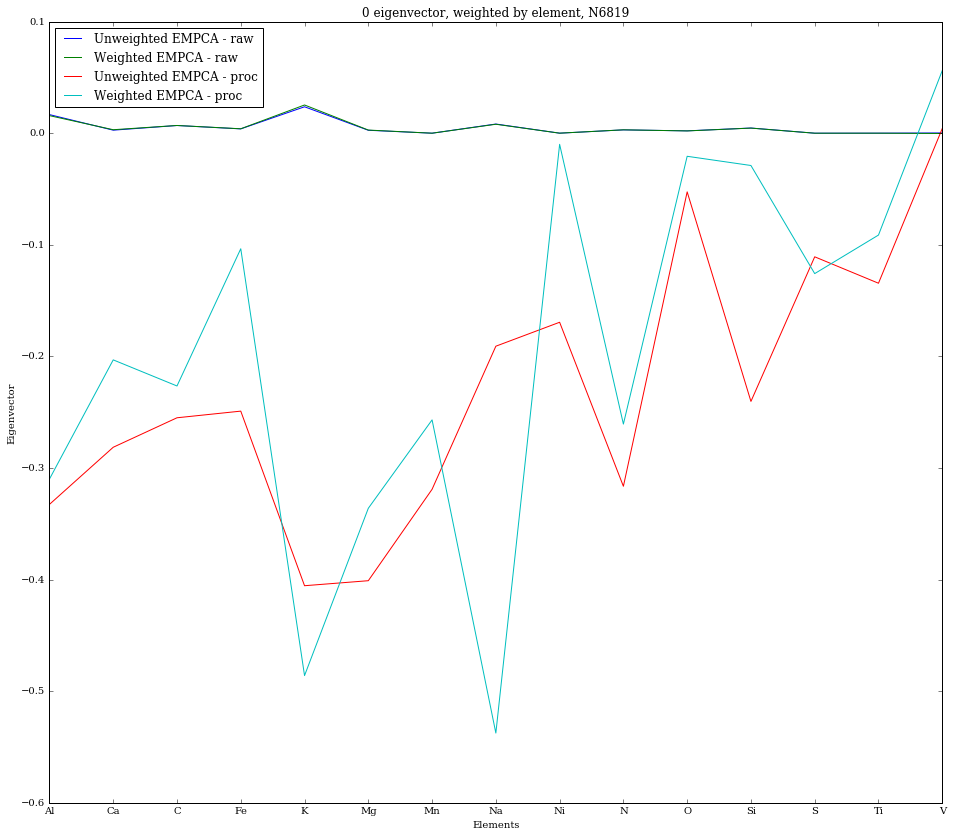

In [9]:
# Do EMPCA for each cluster individually
nvecs = 5

for subgroup in starsample.subgroups:
    print subgroup
    match = np.where(starsample.data[starsample.subgroup]==subgroup)
    empcaname = starsample.outName('pkl',content = 'empca',subgroup=subgroup,order = starsample.order,seed = starsample.seed,cross=starsample.cross)
    empcaname = empcaname.split('.pkl')[0]+'_nvec{0}'.format(nvecs)+'.pkl'
    goodpix = ([i for i in range(aspcappix) if np.sum(starsample.residual[subgroup][i].mask) < starsample.numstars[subgroup]-5],)
    badpix = ([i for i in range(aspcappix) if np.sum(starsample.residual[subgroup][i].mask) < starsample.numstars[subgroup]-5],)
    if os.path.isfile(empcaname):
        empcamodel,empcamodel_weight = acs.pklread(empcaname)
    elif not os.path.isfile(empcaname):
        empca_res = starsample.residual[subgroup][goodpix].T
        mask = (empca_res.mask==False)
        weights = mask.astype(int)
        sigmas = starsample.errs[match].T[goodpix].T
        weights[mask] = 1./sigmas[mask]**2
        empcamodel,runtime1 = timeIt(empca,empca_res,weights = mask.astype(int),nvec=nvecs)
        print 'Runtime:', runtime1/60.,' min'
        empcamodel_weight,runtime2 = timeIt(empca,empca_res,weights = weights,nvec=nvecs)
        print 'Runtime:', runtime2/60.,' min'
        acs.pklwrite(empcaname,[empcamodel,empcamodel_weight])

    Vnoise = (1./(len(match[0])*aspcappix))*np.ma.sum(np.ma.sum(starsample.errs[match]**2,axis=1))
    R2noise = 1 - Vnoise/np.ma.var(starsample.residual[subgroup].T)
    R2 = np.zeros(nvecs)
    R2_w = np.zeros(nvecs)
    for vec in range(nvecs):
        R2[vec] = empcamodel.R2(vec)
        R2_w[vec] = empcamodel_weight.R2(vec)

    empcamodel.eigvec.resize((nvecs,aspcappix))
    empcamodel_weight.eigvec.resize((nvecs,aspcappix))

    neweigvecs = np.zeros((nvecs,len(elems)))
    neweigvecs_w = np.zeros((nvecs,len(elems)))
    for ind in range(len(elems)):
        for vec in range(nvecs):
            newvec = np.ma.masked_array(np.zeros((aspcappix)),mask = np.zeros((aspcappix)))
            newvec[goodpix] = empcamodel.eigvec[vec][:len(goodpix[0])]
            newvec.mask[badpix] = 1
            empcamodel.eigvec[vec] = newvec
            newvec = np.ma.masked_array(np.zeros((aspcappix)),mask = np.zeros((aspcappix)))
            newvec[goodpix] = empcamodel_weight.eigvec[vec][:len(goodpix[0])]
            newvec.mask[badpix] = 1
            empcamodel_weight.eigvec[vec] = newvec
            neweigvecs[vec][ind] = starsample.weighting(empcamodel.eigvec[vec],elems[ind])
            neweigvecs_w[vec][ind] = starsample.weighting(empcamodel_weight.eigvec[vec],elems[ind])

    # Create weighted residuals
    weighted = np.ma.masked_array(np.zeros((len(elems),starsample.numstars[subgroup])))
    weightedsigs = np.ma.masked_array(np.zeros((len(elems),starsample.numstars[subgroup])))
    i=0
    for elem in elems:
        weightedr = starsample.weighting_stars(starsample.residual[subgroup],elem,
                                               starsample.outName('pkl','resids',elem=elem,
                                                                  order = starsample.order,
                                                                  subgroup=subgroup,
                                                                  cross=starsample.cross))
        weighteds = starsample.weighting_stars(starsample.sigma[subgroup],elem,
                                               starsample.outName('pkl','sigma',elem=elem,
                                                                  order = starsample.order,
                                                                  subgroup=subgroup,
                                                                  seed = starsample.seed))
        doubleResidualHistPlot(elem,weightedr,weighteds,
                               starsample.outName('res','residhist',elem = elem,order = starsample.order,
                                                  cross=starsample.cross,seed = starsample.seed,subgroup = subgroup),
                               bins = 50)
        weighted[i] = weightedr
        weightedsigs[i] = weighteds
        i+=1

    # Do EMPCA on weighted residuals
    empcaname = starsample.outName('pkl',content = 'empca_element',order = starsample.order,
                                   seed = starsample.seed,cross=starsample.cross,subgroup=subgroup)
    empcaname = empcaname.split('.pkl')[0]+'_nvec{0}'.format(nvecs)+'.pkl'
    if os.path.isfile(empcaname):
        wempcamodel,wempcamodel_weight = acs.pklread(empcaname)
    elif not os.path.isfile(empcaname):
        mask = np.ones(weighted.T.shape)
        weights = 1./np.sqrt(weightedsigs.T**2) # Correct?
        wempcamodel,runtime1 = timeIt(empca,weighted.T.data,weights = mask.astype(int),nvec=nvecs)
        print 'Runtime:', runtime1/60.,' min'
        wempcamodel_weight,runtime2 = timeIt(empca,weighted.T.data,weights = weights,nvec=nvecs)
        print 'Runtime:', runtime2/60.,' min'
        acs.pklwrite(empcaname,[wempcamodel,wempcamodel_weight])


    wR2 = np.zeros(nvecs)
    wR2_w = np.zeros(nvecs)
    for vec in range(nvecs):
        wR2[vec] = wempcamodel.R2(vec)
        wR2_w[vec] = wempcamodel_weight.R2(vec)

    plt.figure(figsize=(16,14))
    plt.plot(range(nvecs),R2,label='Unweighted EMPCA - raw')
    plt.plot(range(nvecs),R2_w,label='Weighted EMPCA - raw')
    #plt.plot(range(nvecs),wR2,label='Unweighted EMPCA - proc')
    #plt.plot(range(nvecs),wR2_w,label='Weighted EMPCA - proc')
    plt.axhline(R2noise,linestyle='--',color='k',label='Noise Threshold')
    plt.xlabel('Number of eigenvectors')
    plt.ylabel('Variance')
    plt.legend(loc='best')
    plt.xlim(0,nvecs-1)
    plt.title(subgroup)
    plt.savefig('./{0}/empca/empcaR2_{1}_order{2}_seed{3}_cross{4}_nvec{5}.png'.format(starsample.type,subgroup, starsample.order,starsample.seed,starsample.cross,nvecs))
    if hidefigs:
        plt.close()


    for vec in range(1):
        plt.figure(figsize=(16,14))
        plt.xticks(range(len(elems)),elems)
        plt.plot(neweigvecs[vec],label='Unweighted EMPCA - raw')
        plt.plot(neweigvecs_w[vec],label='Weighted EMPCA - raw')
        plt.plot(wempcamodel.eigvec[vec],label = 'Unweighted EMPCA - proc')
        plt.plot(wempcamodel_weight.eigvec[vec], label = 'Weighted EMPCA - proc')
        plt.legend(loc='best')
        plt.xlabel('Elements')
        plt.ylabel('Eigenvector')
        plt.title('{0} eigenvector, weighted by element, {1}'.format(vec,subgroup))
        plt.savefig('./{0}/empca/empcaeig{1}_order{2}_seed{3}_cross{4}_nvec{8}.png'.format(starsample.type,vec, starsample.order,starsample.seed,starsample.cross,label,up,low,nvecs))
        if hidefigs:
            plt.close()


In [10]:
empcaname = starsample.outName('pkl',content = 'empca',order = starsample.order,seed = starsample.seed,cross=starsample.cross)
empcaname = empcaname.split('pkl')[0]+'nvec{0}'.format(nvecs)+'.pkl'
if os.path.isfile(empcaname):
    empcamodel,empcamodel_weight = acs.pklread(empcaname)
elif not os.path.isfile(empcaname):
    mask = (allresids.mask==False)
    weights = mask.astype(int)
    weights[mask] = 1./allsigmas[mask]**2 # Correct?
    empcamodel,runtime1 = timeIt(empca,allresids,weights = mask.astype(int),nvec=nvecs)
    print 'Runtime:', runtime1/60.,' min'
    empcamodel_weight,runtime2 = timeIt(empca,allresids,weights = weights,nvec=nvecs)
    print 'Runtime:', runtime2/60.,' min'
    acs.pklwrite(empcaname,[empcamodel,empcamodel_weight])

       iter        R2             rchi2
EMPCA  1/25       0.02519426      0.00509605
EMPCA  2/25       0.85306149      0.00076402
EMPCA  3/25       0.90039340      0.00051795
EMPCA  4/25       0.87623754      0.00064472
EMPCA  5/25       0.66220830      0.00175944
EMPCA  6/25       0.92532932      0.00038893
EMPCA  7/25       0.86526157      0.00070104
EMPCA  8/25       0.76034127      0.00124759
EMPCA  9/25       0.56854503      0.00224448
EMPCA 10/25       0.16078879      0.00437585
EMPCA 11/25       0.12604014      0.00454663
EMPCA 12/25       0.45422894      0.00284619
EMPCA 13/25      -0.21379510      0.00631964
EMPCA 14/25       0.52590435      0.00246994
EMPCA 15/25       0.83640699      0.00085130
EMPCA 16/25       0.91681765      0.00043252
EMPCA 17/25       0.93762957      0.00032442
EMPCA 18/25       0.96082171      0.00020374
EMPCA 19/25       0.95953540      0.00021035
EMPCA 20/25       0.89843943      0.00052803
EMPCA 21/25       0.66078627      0.00176406
EMPCA 22/25    

In [36]:
len(allsigmas)

87

In [11]:
Vnoise = (1./(len(allsigmas)*aspcappix))*np.ma.sum(np.ma.sum(allsigmas,axis=1))
R2noise = 1 - Vnoise/np.ma.var(allresids)
R2 = np.zeros(nvecs)
R2_w = np.zeros(nvecs)
for vec in range(nvecs):
    R2[vec] = empcamodel.R2(vec)
    R2_w[vec] = empcamodel_weight.R2(vec)

In [ ]:
plt.figure()
plt.plot(range(nvecs),R2,label='Unweighted EMPCA')
plt.plot(range(nvecs),R2_w,label='Weighted EMPCA')
plt.axhline(R2noise,color='red',label='Noise Threshold')
plt.xlabel('Number of eigenvectors')
plt.ylabel('Variance')
plt.legend(loc='best')
plt.xlim(0,nvecs-1)
plt.savefig('./{0}/empca/empcaR2_order{1}_seed{2}_cross{3}_nvec{4}.png'.format(starsample.type, starsample.order,starsample.seed,starsample.cross,nvecs))
if hidefigs:
    plt.close()

M67
N2158
N6791
N6819


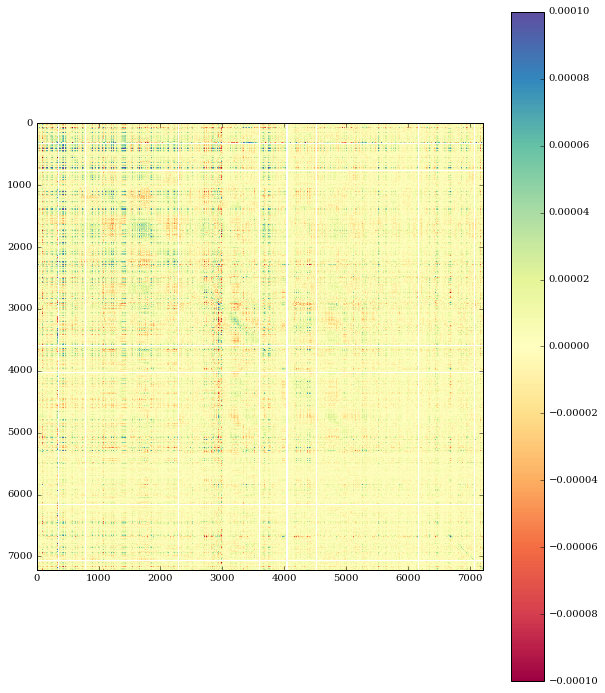

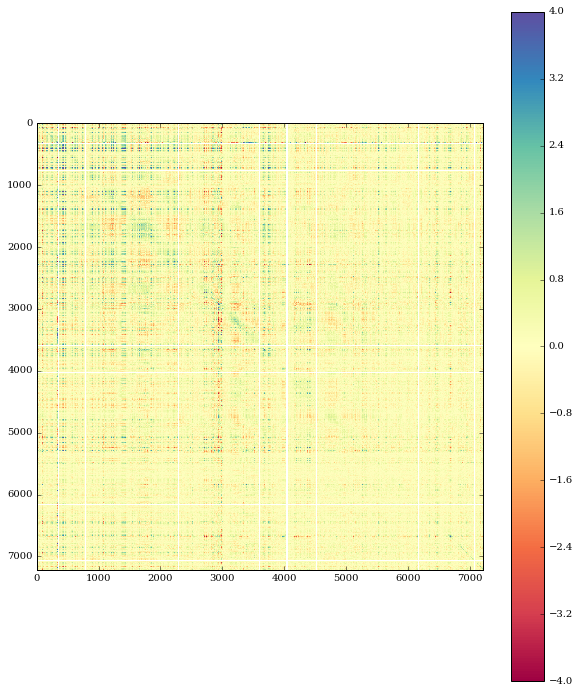

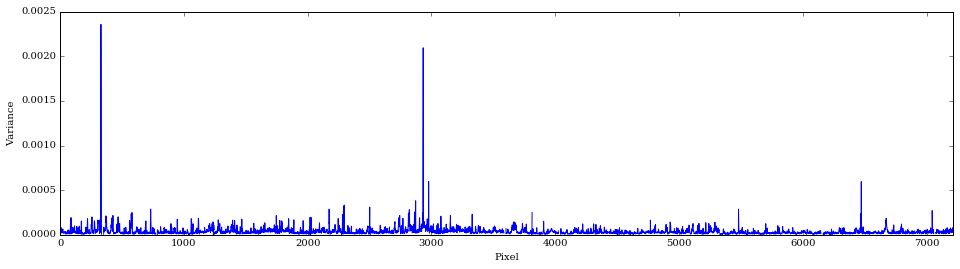

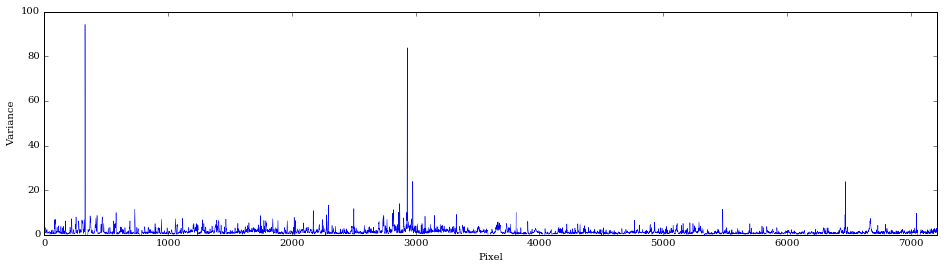

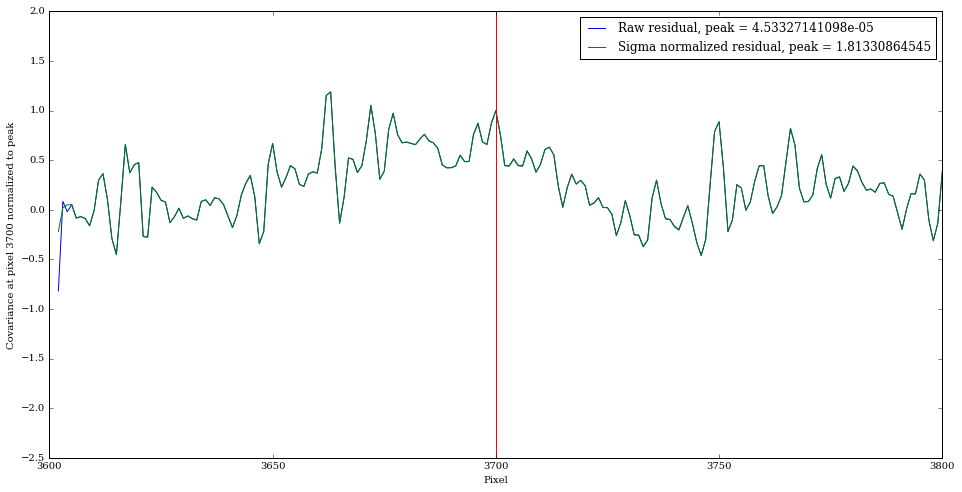

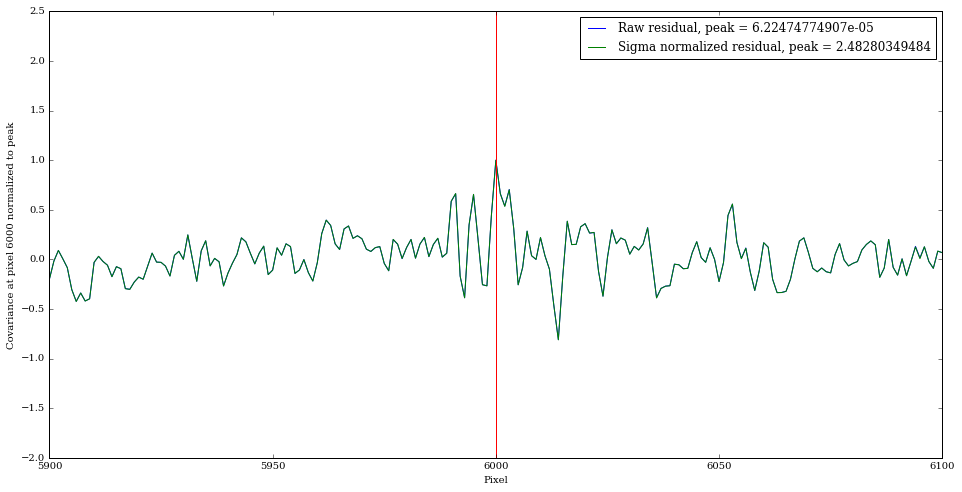

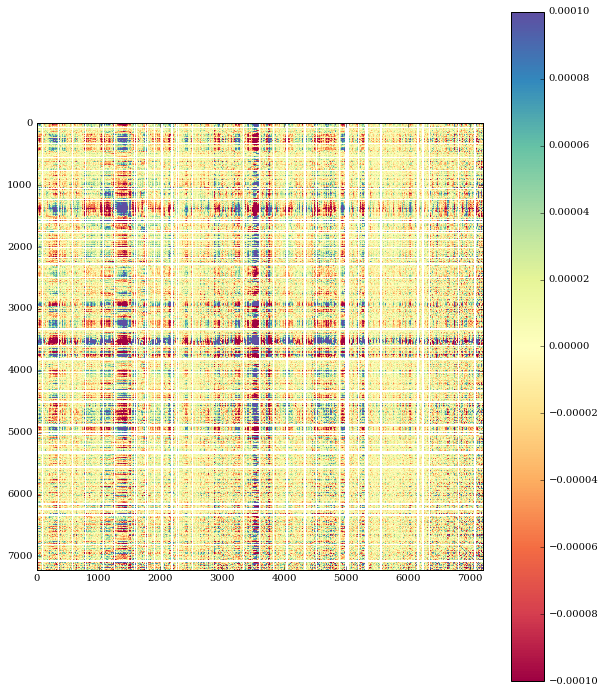

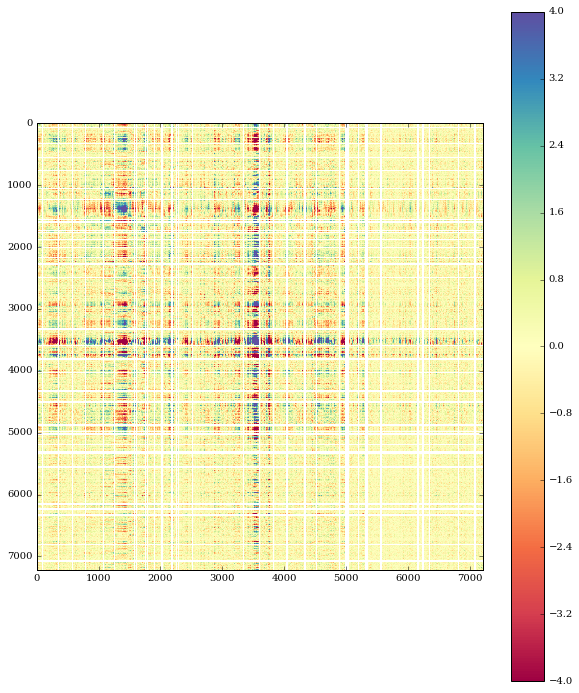

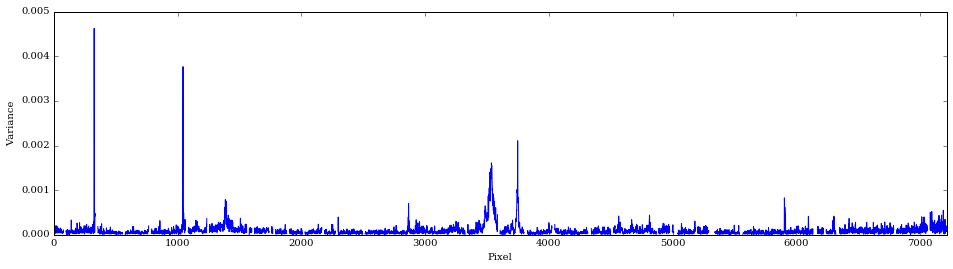

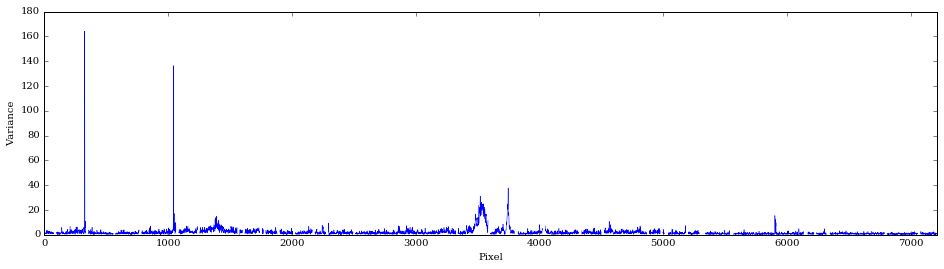

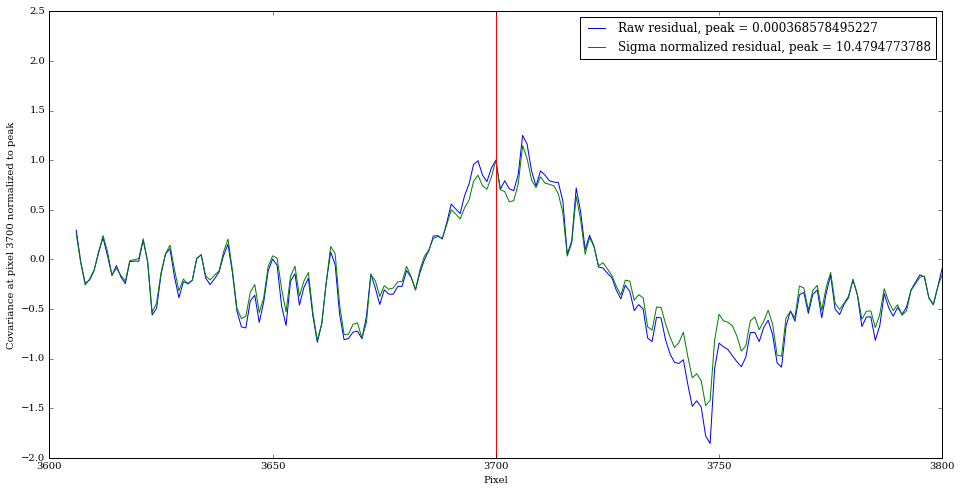

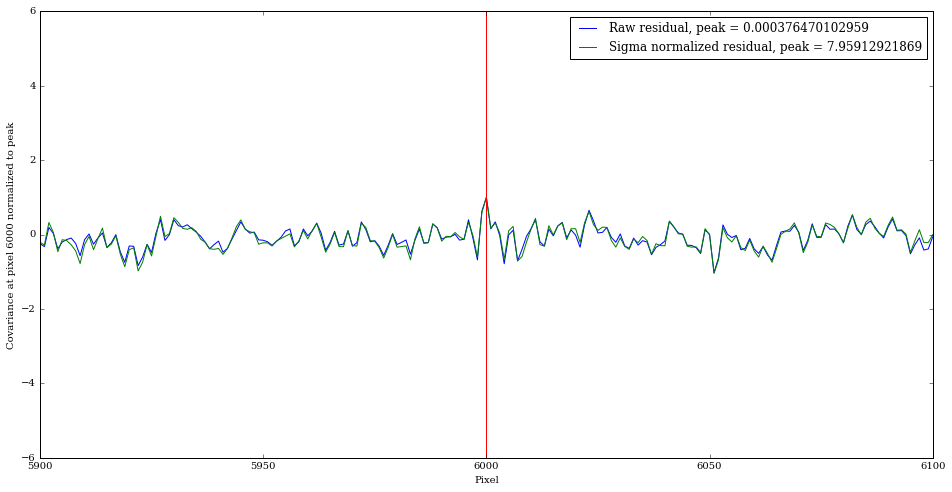

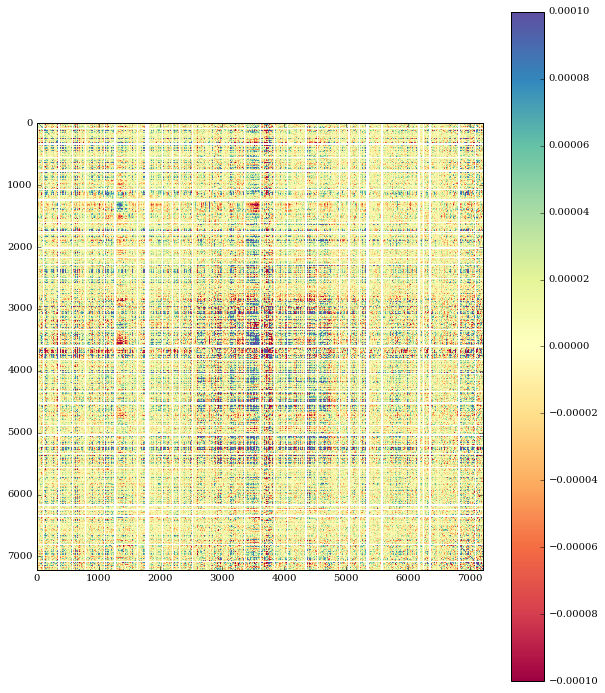

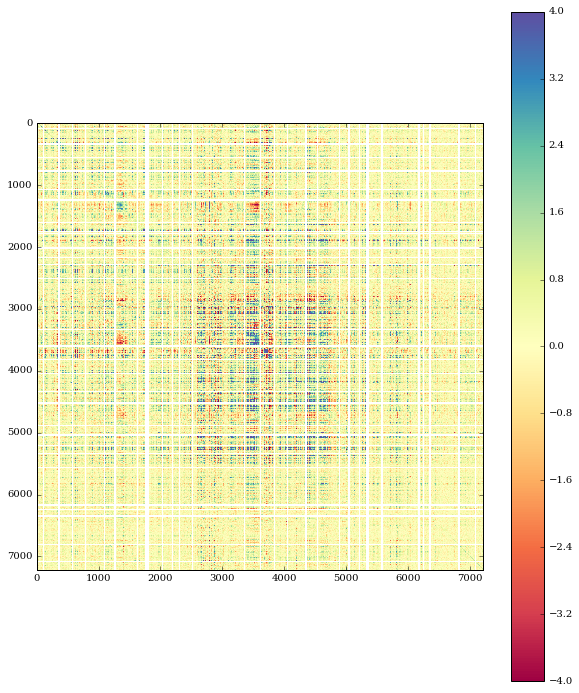

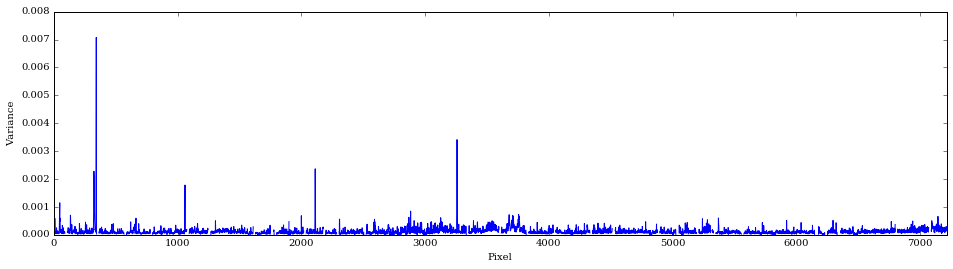

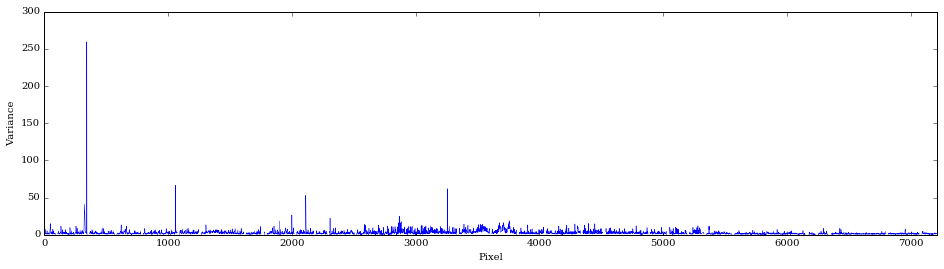

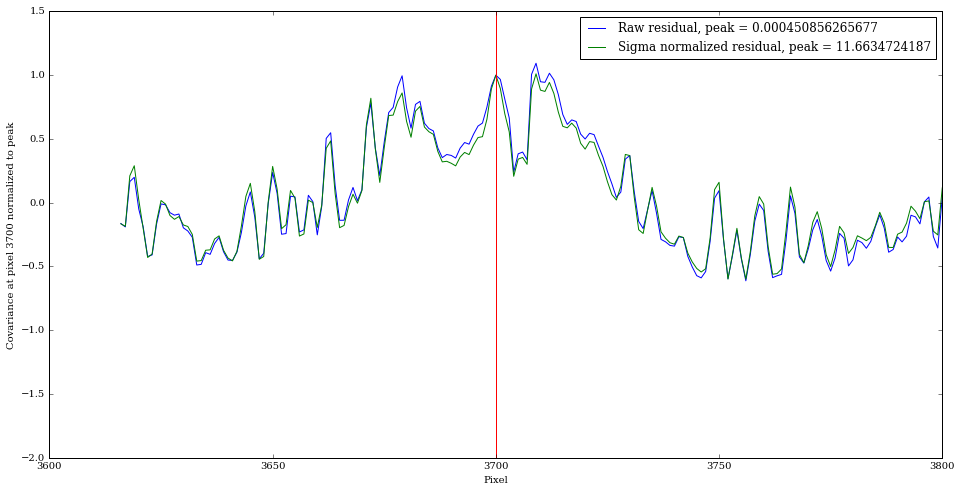

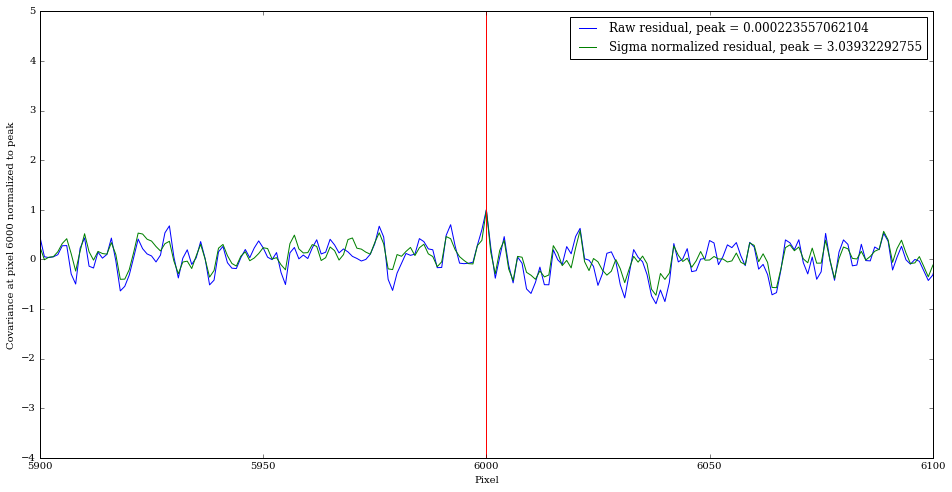

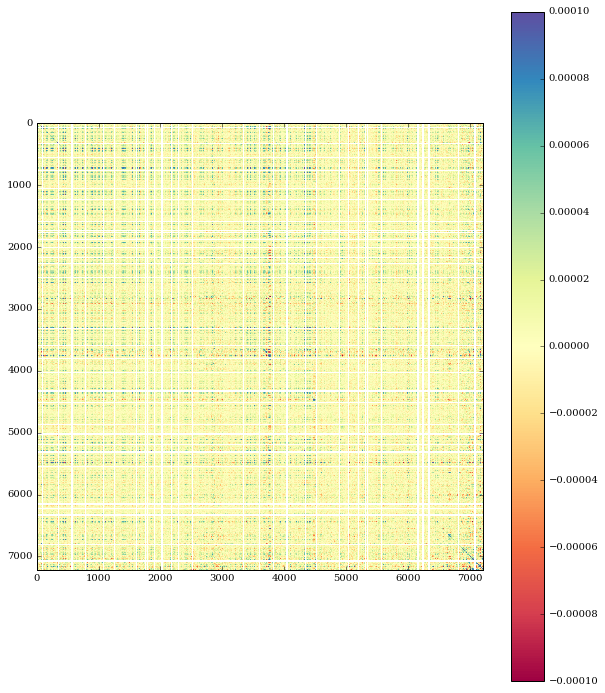

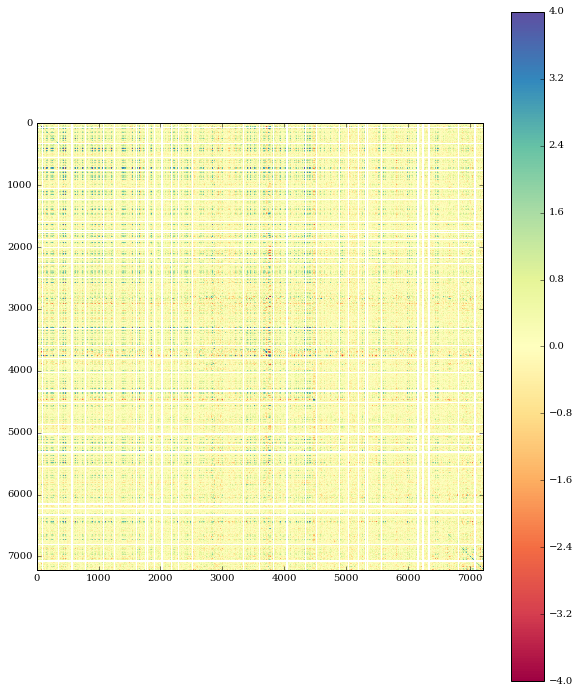

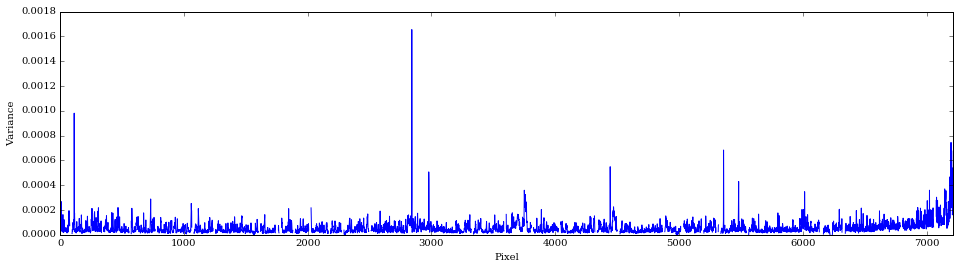

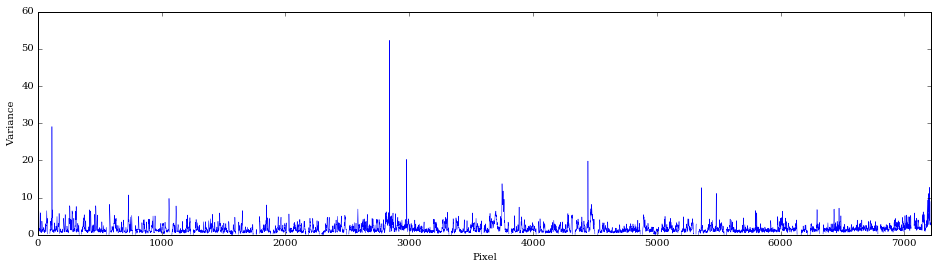

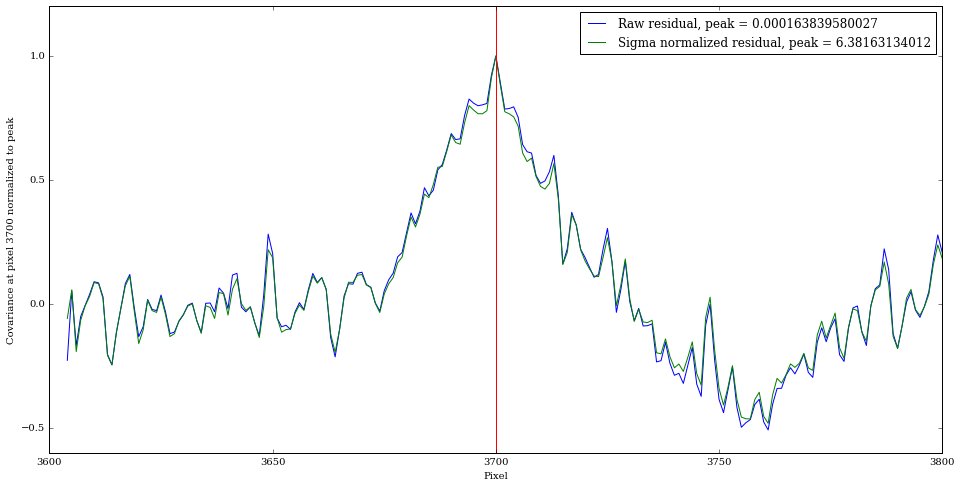

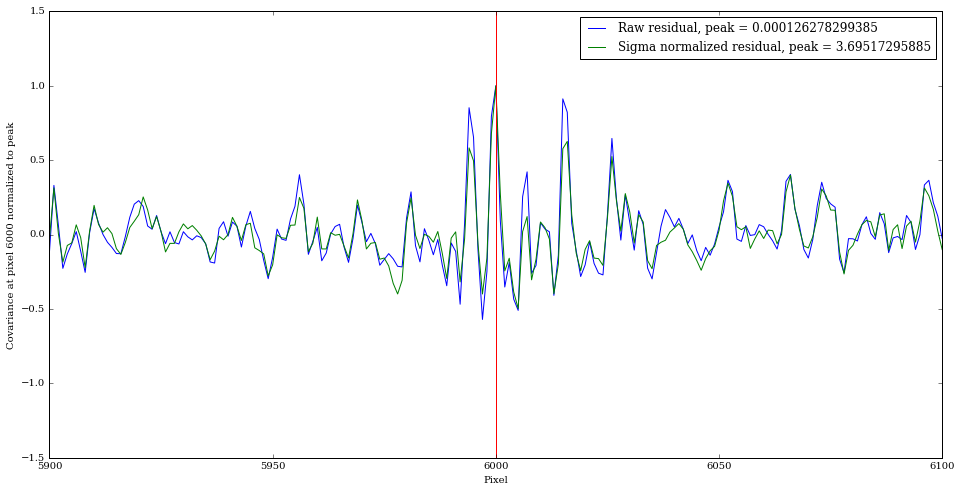

In [12]:
rcovlim = 1e-4
nrcovlim = 4
hidefigs=False
for subgroup in starsample.subgroups:
    print subgroup
    match = np.where(starsample.data[starsample.subgroup]==subgroup)
    residcov = np.ma.cov(starsample.residual[subgroup])
    normresidcov = np.ma.cov(starsample.residual[subgroup]/starsample.errs[match].T)
    
    # Plot covariance of raw pixel residuals
    plt.figure(figsize=(10,12))
    plt.imshow(residcov,interpolation='nearest',cmap = 'Spectral',vmin=-1e-4,vmax=1e-4)
    plt.colorbar()
    plt.savefig('./{0}/covariance/{1}_order{2}_seed{3}_cross{4}.png'.format(starsample.type, subgroup, starsample.order,starsample.seed,starsample.cross))
    if hidefigs:
        plt.close()

    # Plot covariance of residuals divided by pixel flux uncertainty
    plt.figure(figsize=(10,12))
    plt.imshow(normresidcov,interpolation='nearest',cmap = 'Spectral',vmin=-4,vmax=4)
    plt.colorbar()
    plt.savefig('./{0}/covariance/norm_{1}_order{2}_seed{3}_cross{4}.png'.format(starsample.type, subgroup, starsample.order,starsample.seed,starsample.cross))
    if hidefigs:
        plt.close()

    # Plot diagonal of covariance of raw pixel residuals
    plt.figure(figsize=(16,4))
    diag = np.array([residcov[i,i] for i in range(len(residcov))])
    plt.plot(diag)
    plt.xlim(0,len(diag))
    plt.xlabel('Pixel')
    plt.ylabel('Variance')
    plt.savefig('./{0}/covariance/diag_{1}_order{2}_seed{3}_cross{4}.png'.format(starsample.type, subgroup, starsample.order,starsample.seed,starsample.cross))
    if hidefigs:
        plt.close()

    # Plot diagonal of  covariance of residuals divided by pixel flux uncertainty
    plt.figure(figsize=(16,4))
    normdiag = np.array([normresidcov[i,i] for i in range(len(normresidcov))])
    plt.plot(normdiag,linewidth = 0.5)
    plt.xlim(0,len(normdiag))
    plt.xlabel('Pixel')
    plt.ylabel('Variance')
    plt.savefig('./{0}/covariance/normdiag_{1}_order{2}_seed{3}_cross{4}.png'.format(starsample.type, subgroup, starsample.order,starsample.seed,starsample.cross))
    if hidefigs:
        plt.close()

    # Plot two slices of the covariance matrices
    samppix = 3700
    plt.figure(figsize=(16,8))
    plt.plot(residcov[samppix]/residcov[samppix][samppix],label = 'Raw residual, peak = {0}'.format(np.max(residcov[samppix])))
    plt.plot(normresidcov[samppix]/normresidcov[samppix][samppix],label = 'Sigma normalized residual, peak = {0}'.format(np.max(normresidcov[samppix])))
    plt.axvline(samppix,color='red')
    plt.ylabel('Covariance at pixel {0} normalized to peak'.format(samppix))
    plt.xlabel('Pixel')
    plt.xlim(samppix-100,samppix+100)
    plt.legend(loc = 'best')
    plt.savefig('./{0}/covariance/pix{1}_{2}_order{3}_seed{4}_cross{5}.png'.format(starsample.type, samppix,subgroup,starsample.order,starsample.seed,starsample.cross))
    if hidefigs:
        plt.close()

    samppix = 6000
    plt.figure(figsize=(16,8))
    plt.plot(residcov[samppix]/residcov[samppix][samppix],label = 'Raw residual, peak = {0}'.format(np.max(residcov[samppix])))
    plt.plot(normresidcov[samppix]/normresidcov[samppix][samppix],label = 'Sigma normalized residual, peak = {0}'.format(np.max(normresidcov[samppix])))
    plt.axvline(samppix,color='red')
    plt.ylabel('Covariance at pixel {0} normalized to peak'.format(samppix))
    plt.xlabel('Pixel')
    plt.xlim(samppix-100,samppix+100)
    plt.legend(loc = 'best')
    plt.savefig('./{0}/covariance/pix{1}_{2}_order{3}_seed{4}_cross{5}.png'.format(starsample.type, samppix,subgroup,starsample.order,starsample.seed,starsample.cross))
    if hidefigs:
        plt.close()

In [9]:
residcov = np.ma.cov(allresids.T)
normresidcov = np.ma.cov(allresids.T/allsigmas.T)

In [10]:
rcovlim = 1e-4
nrcovlim = 4

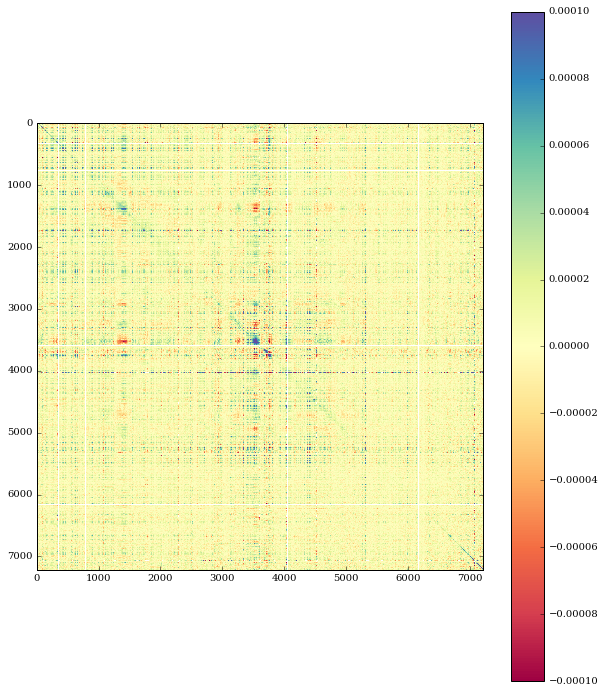

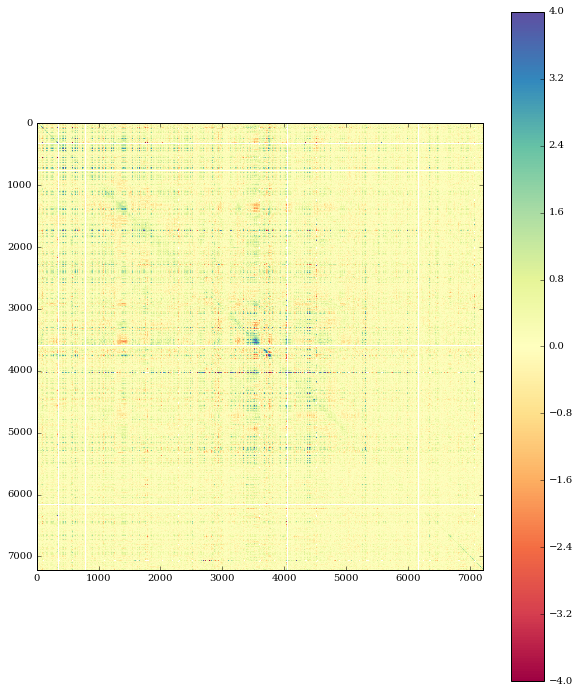

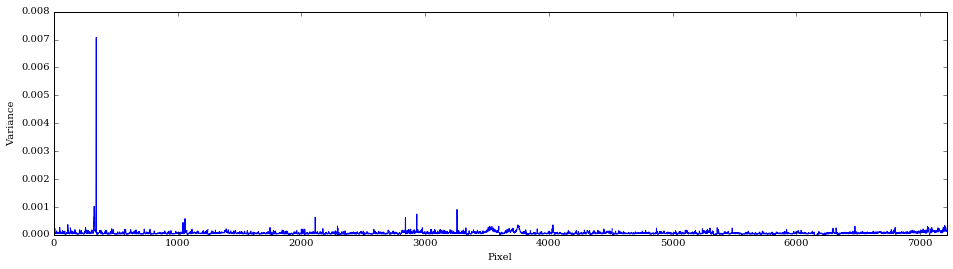

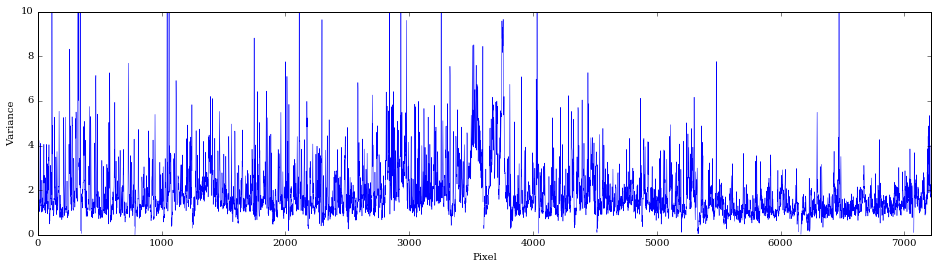

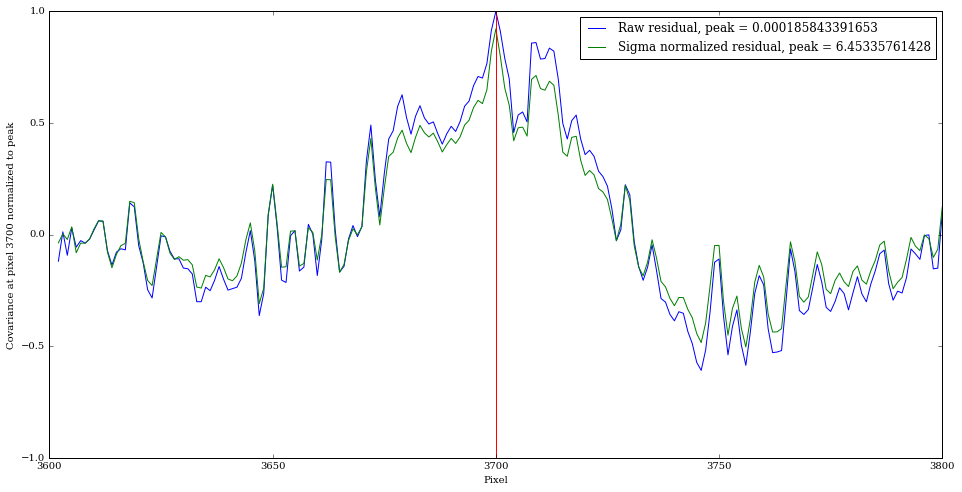

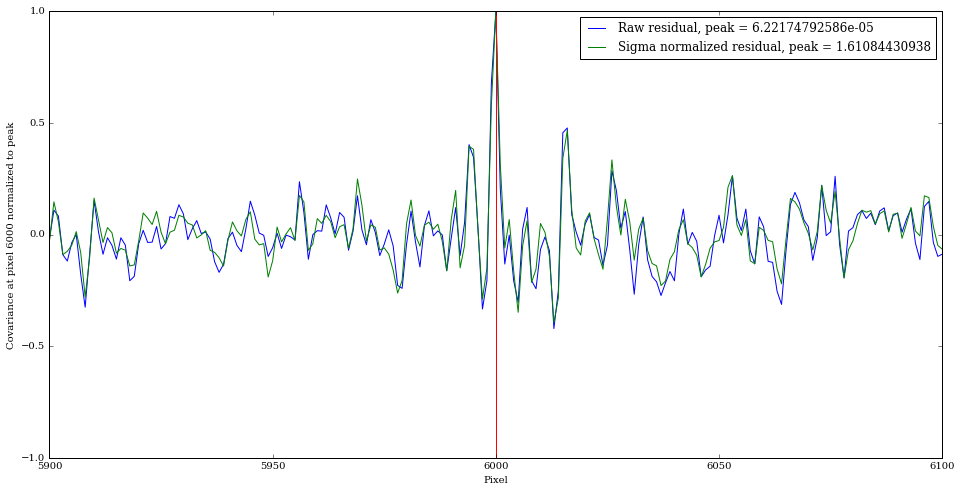

In [11]:
# Plot covariance of raw pixel residuals
plt.figure(figsize=(10,12))
plt.imshow(residcov,interpolation='nearest',cmap = 'Spectral',vmax=rcovlim,vmin=-rcovlim)
plt.colorbar()
plt.savefig('./{0}/covariance/order{1}_seed{2}_cross{3}.png'.format(starsample.type, starsample.order,starsample.seed,starsample.cross))
if hidefigs:
    plt.close()

# Plot covariance of residuals divided by pixel flux uncertainty
plt.figure(figsize=(10,12))
plt.imshow(normresidcov,interpolation='nearest',cmap = 'Spectral',vmax=nrcovlim,vmin=-nrcovlim)
plt.colorbar()
plt.savefig('./{0}/covariance/norm_order{1}_seed{2}_cross{3}.png'.format(starsample.type, starsample.order,starsample.seed,starsample.cross))
if hidefigs:
    plt.close()

# Plot diagonal of covariance of raw pixel residuals
plt.figure(figsize=(16,4))
diag = np.array([residcov[i,i] for i in range(len(residcov))])
plt.plot(diag)
plt.xlim(0,len(diag))
plt.xlabel('Pixel')
plt.ylabel('Variance')
plt.savefig('./{0}/covariance/diag_order{1}_seed{2}_cross{3}.png'.format(starsample.type, starsample.order,starsample.seed,starsample.cross))
if hidefigs:
    plt.close()

# Plot diagonal of  covariance of residuals divided by pixel flux uncertainty
plt.figure(figsize=(16,4))
normdiag = np.array([normresidcov[i,i] for i in range(len(normresidcov))])
plt.plot(normdiag,linewidth = 0.5)
plt.xlim(0,len(normdiag))
plt.ylim(0,10)
plt.xlabel('Pixel')
plt.ylabel('Variance')
plt.savefig('./{0}/covariance/normdiag_order{1}_seed{2}_cross{3}.png'.format(starsample.type, starsample.order,starsample.seed,starsample.cross))
if hidefigs:
    plt.close()

# Plot two slices of the covariance matrices
samppix = 3700
plt.figure(figsize=(16,8))
plt.plot(residcov[samppix]/np.max(residcov[samppix]),label = 'Raw residual, peak = {0}'.format(np.max(residcov[samppix])))
plt.plot(normresidcov[samppix]/np.max(normresidcov[samppix]),label = 'Sigma normalized residual, peak = {0}'.format(np.max(normresidcov[samppix])))
plt.axvline(samppix,color='red')
plt.ylabel('Covariance at pixel {0} normalized to peak'.format(samppix))
plt.xlabel('Pixel')
plt.xlim(samppix-100,samppix+100)
plt.legend(loc = 'best')
plt.savefig('./{0}/covariance/pix{1}_order{2}_seed{3}_cross{4}.png'.format(starsample.type, samppix,starsample.order,starsample.seed,starsample.cross))
if hidefigs:
    plt.close()

samppix = 6000
plt.figure(figsize=(16,8))
plt.plot(residcov[samppix]/np.max(residcov[samppix]),label = 'Raw residual, peak = {0}'.format(np.max(residcov[samppix])))
plt.plot(normresidcov[samppix]/np.max(normresidcov[samppix]),label = 'Sigma normalized residual, peak = {0}'.format(np.max(normresidcov[samppix])))
plt.axvline(samppix,color='red')
plt.ylabel('Covariance at pixel {0} normalized to peak'.format(samppix))
plt.xlabel('Pixel')
plt.xlim(samppix-100,samppix+100)
plt.legend(loc = 'best')
plt.savefig('./{0}/covariance/pix{1}_order{2}_seed{3}_cross{4}.png'.format(starsample.type, samppix,starsample.order,starsample.seed,starsample.cross))
if hidefigs:
    plt.close()